# Initialization

In [1]:
USE_MP = True
import silq

silq.initialize("EWJN")

qc.show_subprocess_widget()
%matplotlib nbagg

Initializing imports


<IPython.core.display.Javascript object>

Initializing functions
Initializing instruments
Initializing layout
Initializing data
Initializing analysis
Initializing parameters
Initializing plotting
Initialization complete


## Common settings

In [11]:
frequency_center_ESR = {'up': 27.852e9, 'down': 27.951e9}
frequency_center_NMR = 66.5e6

DF_DS(0.4138)
TGAC(0.484)

## Threshold voltage

In [12]:
EPR_parameter.setup(samples=50)
EPR_parameter()
traces_read = EPR_parameter.trace_segments['output']['read']
_, _, readout_threshold_voltage = analysis.find_high_low(traces_read)
assert readout_threshold_voltage is not None, "Couldn't find accurate threshold"
print('Threshold voltage found at {:.2f} V'.format(readout_threshold_voltage))

Threshold voltage found at 0.42 V


# DC Measurements

## DC - Turnon
Here several gates are combined to the parameter turnon_param.

In [8]:
turnon_vals = turnon_parameter[list(np.linspace(1, 1.6, 100))]

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-07/#021_turnon_16-30-57'
   <Type>   | <array_id>   | <array.name> | <array.shape>
   Setpoint | TG_LB_RB_set | TG_LB_RB     | (100,)
   Measured | DC_voltage   | DC_voltage   | (100,)
started at 2016-12-07 16:31:01


<IPython.core.display.Javascript object>


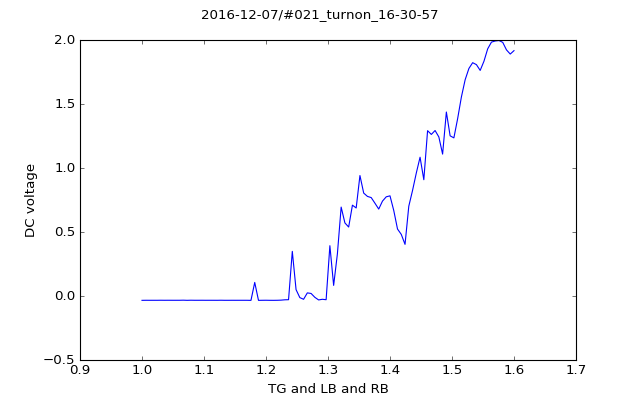

In [10]:
DC_parameter.setup()
data = qc.Loop(turnon_vals
# data = qc.Loop(dummy_parameter[0:1000:1], delay=1
               ).each(DC_parameter
                      ).then(qc.Task(layout.stop)
                             ).run(name='turnon',
                                   progress_interval=True)
plot = qc.MatPlot(data.DC_voltage)

## DC - Pinchoff
This code pinches off one gate, while keeping the other gates fixed

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-07/#015_Pinchoff_TG_14-39-22'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Setpoint | TG_set     | TG           | (100,)
   Measured | DC_voltage | DC_voltage   | (100,)
started at 2016-12-07 14:39:26


<IPython.core.display.Javascript object>


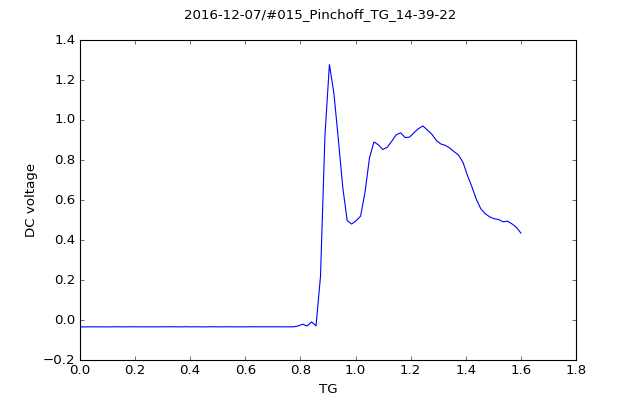

In [63]:
turnon_voltage = 1.6
pinchoff_vals = list(np.linspace(turnon_voltage, 0, 100))
gate = TG

turnon_parameter(turnon_voltage)
DC_parameter.setup()
data = qc.Loop(gate[pinchoff_vals]
               ).each(DC_parameter
                      ).then(qc.Task(layout.stop)
                             ).run(name='Pinchoff_{}'.format(gate.name),
                                   progress_interval=True)
plot = qc.MatPlot(data.DC_voltage)

In [113]:
layout.stop()

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-07/#018_2D_Pinchoff_TG_14-58-27'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Setpoint | RB_set     | RB           | (40,)
   Setpoint | LB_set     | LB           | (40, 40)
   Measured | DC_voltage | DC_voltage   | (40, 40)
started at 2016-12-07 14:58:31


<IPython.core.display.Javascript object>


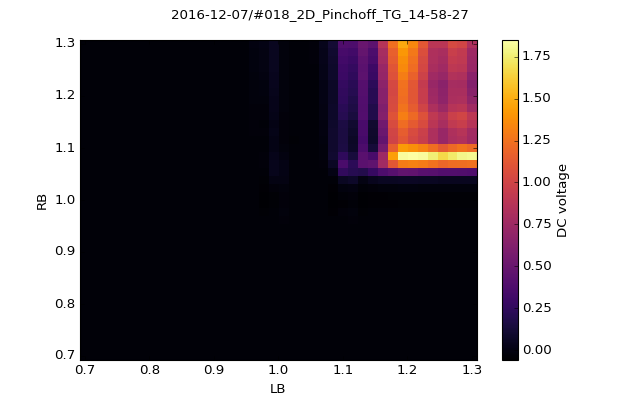

In [68]:
turnon_voltage = 1.3
pinchoff_vals = list(np.linspace(turnon_voltage, 0.7, 40))
gatex=LB
gatey=RB

turnon_parameter(turnon_voltage)
DC_parameter.setup()
data = qc.Loop(gatey[pinchoff_vals]
               ).loop(gatex[pinchoff_vals]
                      ).each(DC_parameter
                      ).then(qc.Task(layout.stop)
                             ).run(name='2D_Pinchoff_{}'.format(gate.name),
                                   progress_interval=True)
plot = qc.MatPlot(data.DC_voltage)


## DC - 1D scan
This script performs a 1D DC scan

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-07/#011_DC_DF_DS_scan_14-23-17'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Setpoint | DF_DS_set  | DF_DS        | (50,)
   Measured | DC_voltage | DC_voltage   | (50,)
started at 2016-12-07 14:23:19


<IPython.core.display.Javascript object>


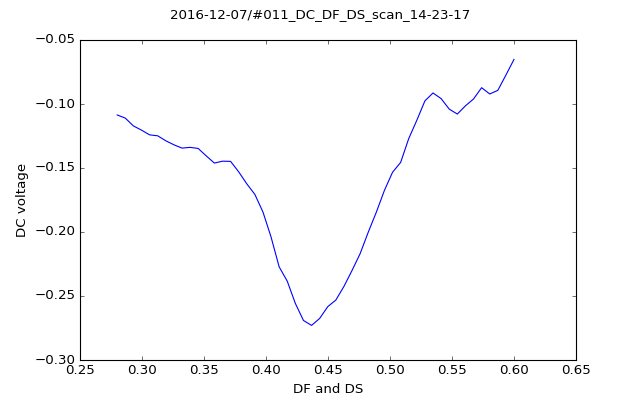

In [53]:
gate = DF_DS[list(np.linspace(0.28,0.6, 50))]

DC_parameter.setup()
data = qc.Loop(gate
              ).each(DC_parameter
                    ).then(qc.Task(layout.stop)
                          ).run(name='DC_{}_scan'.format(gate.name),
                                progress_interval=True)

plot = qc.MatPlot(data.DC_voltage)

## DC - 2D scan
This measurement performs a 2D DC scan

In [21]:

def print_voltages(SIM900):
    output_str = '{\n'
    for channel, name in SIM900.channels().items():
        output_str += '{}: {}\n'.format(name, SIM900.parameters[name]())
    output_str += '}'
    return output_str

In [24]:

def ramp_to_voltages(target_voltages, SIM900=None, channels=None):
    if channels is None:
        channels = [SIM900.parameters[ch_name] for ch_name in
                    SIM900.channels().values()]

    if isinstance(target_voltages, int):
        target_voltages = {channel.name: target_voltages for channel in
                           channels}

    initial_voltages = {channel.name: channel() for channel in channels}
    for ratio in np.linspace(0, 1, 11):
        for channel in channels:
            voltage = (1 - ratio) * initial_voltages[channel.name] + \
                      ratio * target_voltages[channel.name]
            channel(voltage)

In [115]:
ramp_to_voltages(0, SIM900)


In [100]:

def get_voltages(SIM900):
    voltages = {}

    for channel, name in SIM900.channels().items():
        voltages[name] = SIM900.parameters[name]()
    return voltages

In [116]:
ramp_to_voltages(voltages, SIM900)

In [102]:
voltages

{'DF_raw': 1.4,
 'DS_raw': 1.4,
 'LB_raw': 3.92,
 'RB_raw': 3.92,
 'SRC_raw': 0.25,
 'TGAC_raw': 2.357,
 'TG_raw': 16.48}

In [103]:
SIM900.reset_slot(4)

In [112]:
DS()

0.34

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-08/#013_DC_TGAC_vs_DF_DS_scan_12-14-22'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Setpoint | TGAC_set   | TGAC         | (15,)
   Setpoint | DF_DS_set  | DF_DS        | (15, 40)
   Measured | DC_voltage | DC_voltage   | (15, 40)
started at 2016-12-08 12:14:25


<IPython.core.display.Javascript object>


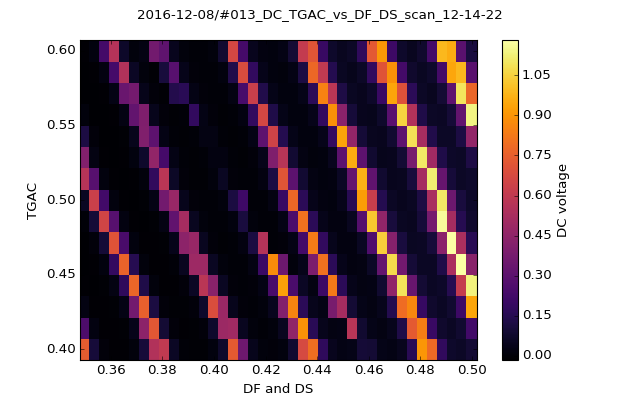

In [40]:
gate_x = DF_DS[list(np.linspace(0.35, 0.5, 40))]
gate_y = TGAC[list(np.linspace(0.4,0.6, 15))]

DC_parameter.setup()
data = qc.Loop(gate_y
              ).loop(gate_x
                    ).each(DC_parameter
                          ).then(qc.Task(layout.stop)
                                ).run(name='DC_{}_vs_{}_scan'.format(gate_y.name, gate_x.name),
                                      progress_interval=True)

plot = qc.MatPlot(data.DC_voltage)

# EPR measurements (no steering/ESR)
This is a calibration routine to find a point with high contrast (difference in signal between up state and down state). 
This measurement consists of three stages: empty, load, and read.
In the empty stage, the donor atom is ionized. 
It is then loaded with an electron in a random state.
Finally the state is read out for a long duration.
The contrast is found by looking if blips occured at the beginning of the read trace and at the end of the read trace.
The contrast is the difference in percentage of blips occuring at the beginning versus at the end.
The end part of the read trace is related to the number of dark counts, since we assume that an up-state electron will have had enough time to have tunneled off and on again.

## EPR - Parameter settings

In [41]:
EPR_parameter.pulse_sequence['read'].duration = 80
EPR_parameter.pulse_sequence['plunge'].amplitude = 1.8

EPR_parameter.pulse_sequence

PulseSequence with 4 pulses, duration: 92
	DCPulse(empty, A=-1.5, t_start=0, t_stop=5)
	DCPulse(plunge, A=1.8, t_start=5, t_stop=10)
	DCPulse(read, A=0, t_start=10, t_stop=90)
	DCPulse(final, A=0, t_start=90, t_stop=92)

## EPR - 2D scan

In [6]:
DF_DS_vals = list(np.linspace(0.413, 0.419, 8))
TGAC_vals = list(np.linspace(0.47,0.49, 8))

In [7]:
EPR_parameter.setup(samples=80, t_read=20)
data = qc.Loop(TGAC[TGAC_vals]
              ).loop(DF_DS[DF_DS_vals]
                    ).each(EPR_parameter
                          ).run(name='EPR_calibration',
                                progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-09/#001_EPR_calibration_10-00-07'
   <Type>   | <array_id>     | <array.name>   | <array.shape>
   Setpoint | TGAC_set       | TGAC           | (8,)
   Setpoint | DF_DS_set      | DF_DS          | (8, 8)
   Measured | fidelity_empty | fidelity_empty | (8, 8)
   Measured | fidelity_load  | fidelity_load  | (8, 8)
   Measured | fidelity_read  | fidelity_read  | (8, 8)
   Measured | up_proportion  | up_proportion  | (8, 8)
   Measured | dark_counts    | dark_counts    | (8, 8)
   Measured | contrast       | contrast       | (8, 8)
started at 2016-12-09 10:00:11


<IPython.core.display.Javascript object>


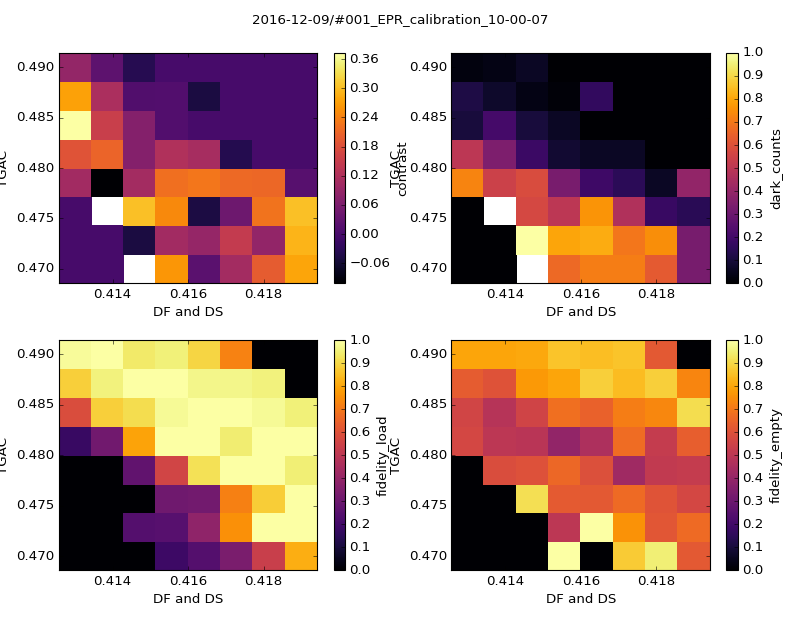

In [8]:
plot = CalibrationPlot(data)
# ax = plot.plot.subplots[0]
# ax.qcodes_colorbar.set_clim(0,0.35)

## EPR - Single point

In [9]:
DF_DS(0.41665)
TGAC(0.4784)

In [10]:
EPR_parameter.setup(samples=150, print_results=True)
EPR_parameter();

fidelity_empty: 0.541
fidelity_load: 0.875
fidelity_read: 0.639
up_proportion: 0.379
dark_counts: 0.139
contrast: 0.240


# Adiabatic sweep measurements

## ESR Adiabatic - Parameter settings

In [17]:
### setup
## ESR 
adiabatic_ESR_parameter.pulse_sequence['empty'].enabled = False
adiabatic_ESR_parameter.pulse_sequence['plunge'].amplitude = 1.8
adiabatic_ESR_parameter.pulse_sequence['plunge'].duration = 5

adiabatic_ESR_parameter.pulse_sequence['steered_initialization'].enabled = False
adiabatic_ESR_parameter.pulse_sequence['steered_initialization'].t_buffer = 30
adiabatic_ESR_parameter.pulse_sequence['steered_initialization'].t_no_blip = 90
adiabatic_ESR_parameter.pulse_sequence['steered_initialization'].t_max_wait = 400

adiabatic_ESR_parameter.pulse_sequence['adiabatic_sweep'].frequency_deviation=5e6
adiabatic_ESR_parameter.pulse_sequence['adiabatic_sweep'].duration = 0.15
adiabatic_ESR_parameter.pulse_sequence['adiabatic_sweep'].enabled = True
adiabatic_ESR_parameter.pulse_sequence['adiabatic_sweep'].t_start = 4

adiabatic_ESR_parameter.pulse_sequence['read'].duration=120

adiabatic_ESR_parameter.setup(samples=50,
                                    readout_threshold_voltage=readout_threshold_voltage)


## NMR
adiabatic_NMR_parameter.pulse_sequence['empty'].enabled = False

adiabatic_NMR_parameter.pulse_sequence['plunge'].amplitude = 1.8
adiabatic_NMR_parameter.pulse_sequence['plunge'].duration = 5

adiabatic_NMR_parameter.pulse_sequence['steered_initialization'].enabled = False
adiabatic_NMR_parameter.pulse_sequence['steered_initialization'].t_buffer = 30
adiabatic_NMR_parameter.pulse_sequence['steered_initialization'].t_no_blip = 90
adiabatic_NMR_parameter.pulse_sequence['steered_initialization'].t_max_wait = 400

adiabatic_NMR_parameter.pulse_sequence['adiabatic_sweep'].frequency_deviation=100e3
adiabatic_NMR_parameter.pulse_sequence['adiabatic_sweep'].duration = 0.5
adiabatic_NMR_parameter.pulse_sequence['adiabatic_sweep'].enabled = True
adiabatic_NMR_parameter.pulse_sequence['adiabatic_sweep'].t_start = 4

adiabatic_NMR_parameter.pulse_sequence['read'].duration=120

adiabatic_NMR_parameter.setup(samples=1, readout_threshold_voltage=readout_threshold_voltage)
adiabatic_NMR_parameter(frequency_center_NMR)


# Find ESR frequency
find_ESR_parameter.frequencies_ESR = frequency_center_ESR

find_ESR_parameter.pulse_sequence['steered_initialization'].enabled = False
find_ESR_parameter.pulse_sequence['read'].duration = 120
find_ESR_parameter.pulse_sequence['adiabatic_sweep'].frequency_deviation = 5e6
find_ESR_parameter.pulse_sequence['adiabatic_sweep'].t_start = 4
find_ESR_parameter.pulse_sequence['adiabatic_sweep'].duration = 0.15
find_ESR_parameter.setup(samples=20, print_results=True, readout_threshold_voltage=readout_threshold_voltage)
find_ESR_parameter.pulse_sequence

PulseSequence with 6 pulses, duration: 127
	DCPulse(plunge, A=1.8, t_start=0, t_stop=5)
	DCPulse(read, A=0, t_start=5, t_stop=125)
	FrequencyRampPulse(adiabatic_sweep, f_start=19997.50 MHz, f_stop=20002.50, A=None, t_start=4, t_stop=4.15)
	DCPulse(final, A=0, t_start=125, t_stop=127)
	
	Disabled pulses:
	DCPulse(empty, A=-1.5, t_start=0, t_stop=5)
	SteeredInitialization(steered_initialization, t_no_blip=30 ms, t_max_wait=200, t_buffer=20)

## ESR Adiabatic - Center frequency scan

This code sweeps over the adiabatic sweep center frequency to find the ESR frequency.

To find the ESR frequency, use 28GHz * B0 as starting point, and search around that frequency.
Use a big initial frequency_deviation (around 60 MHz) and long duration (0.5 ms)
Once you see a spike in contrast, center around there and decrease both deviation and duration.

In [85]:
f_center = 27.9e9
f_span = 200e6
f_step = 2e6
adiabatic_sweep_vals = list(np.arange(f_center-f_span/2, f_center+f_span/2, f_step))
print('Sweep vals: {}'.format(len(adiabatic_sweep_vals)))

Sweep vals: 100


DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-06/#003_adiabatic_sweep_10-44-48'
   <Type>   | <array_id>          | <array.name>    | <array.shape>
   Setpoint | adiabatic_sweep_set | adiabatic_sweep | (25,)
   Measured | fidelity_load       | fidelity_load   | (25,)
   Measured | fidelity_read       | fidelity_read   | (25,)
   Measured | up_proportion       | up_proportion   | (25,)
   Measured | dark_counts         | dark_counts     | (25,)
   Measured | contrast            | contrast        | (25,)
started at 2016-12-06 10:44:51


<IPython.core.display.Javascript object>


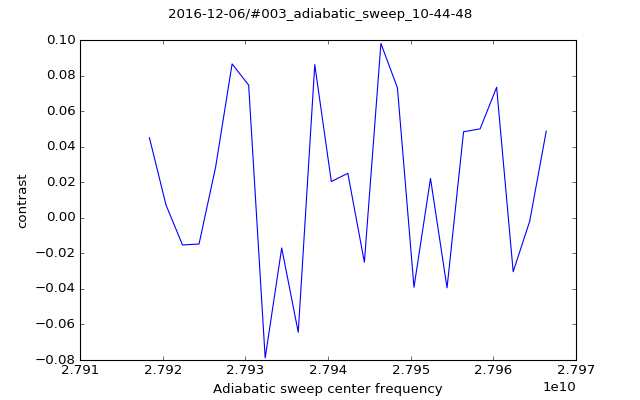

In [17]:
adiabatic_ESR_parameter.setup(samples=80, readout_threshold_voltage=readout_threshold_voltage)
data = qc.Loop(adiabatic_ESR_parameter[adiabatic_sweep_vals]
                     ).each(adiabatic_ESR_parameter
                           ).run(name='adiabatic_ESR_f_center',
                                progress_interval=True)
plot = qc.MatPlot(data.contrast, use_offset=False)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-07/#032_adiabatic_sweep_22-01-41'
   <Type>   | <array_id>          | <array.name>    | <array.shape>
   Setpoint | dummy_set           | dummy           | (400,)
   Setpoint | adiabatic_sweep_set | adiabatic_sweep | (400, 100)
   Measured | fidelity_load       | fidelity_load   | (400, 100)
   Measured | fidelity_read       | fidelity_read   | (400, 100)
   Measured | up_proportion       | up_proportion   | (400, 100)
   Measured | dark_counts         | dark_counts     | (400, 100)
   Measured | contrast            | contrast        | (400, 100)
started at 2016-12-07 22:01:45


<IPython.core.display.Javascript object>


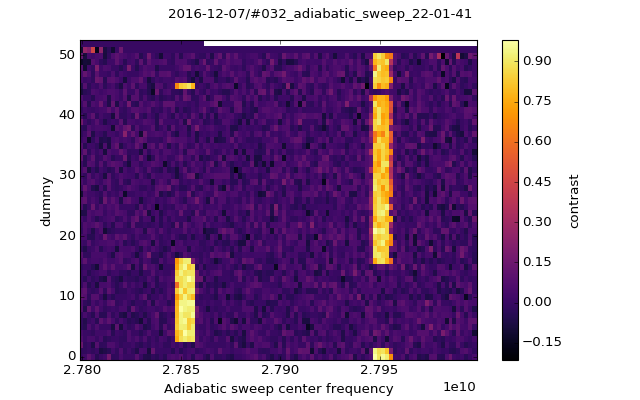

In [86]:
adiabatic_ESR_parameter.setup(samples=50, readout_threshold_voltage=readout_threshold_voltage)
data = qc.Loop(dummy_parameter[0:400:1]
              ).loop(adiabatic_ESR_parameter[adiabatic_sweep_vals]
                    ).each(adiabatic_ESR_parameter
                          ).run(name='ESR_adiabatic_sweep',
                                progress_interval=True)
plot = qc.MatPlot(data.contrast, use_offset=False)

## NMR adiabatic frequency scan

In [40]:
#NMR sweep frequencies
f_center = 66.82e6
f_span = 3e6
f_step = 20e3
NMR_vals = list(np.arange(f_center-f_span/2, f_center+f_span/2, f_step))
print('Sweep vals: {}'.format(len(NMR_vals)))

Sweep vals: 150


In [41]:
data = qc.Loop(adiabatic_NMR_parameter[NMR_vals]
              ).each(qc.Task(adiabatic_NMR_parameter.setup),
                     adiabatic_NMR_parameter,
                     qc.Task(partial(adiabatic_ESR_parameter, frequency_center_ESR['up'])),
                     adiabatic_ESR_parameter,
                     qc.Task(partial(adiabatic_ESR_parameter, frequency_center_ESR['down'])),
                     adiabatic_ESR_parameter,
                    ).run(name='NMR_adiabatic_sweep', progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-08/#023_NMR_adiabatic_sweep_15-52-43'
   <Type>   | <array_id>          | <array.name>    | <array.shape>
   Setpoint | adiabatic_sweep_set | adiabatic_sweep | (150,)
   Measured | fidelity_load_1_0   | fidelity_load   | (150,)
   Measured | fidelity_read_1_1   | fidelity_read   | (150,)
   Measured | up_proportion_1_2   | up_proportion   | (150,)
   Measured | dark_counts_1_3     | dark_counts     | (150,)
   Measured | contrast_1_4        | contrast        | (150,)
   Measured | fidelity_load_3_0   | fidelity_load   | (150,)
   Measured | fidelity_read_3_1   | fidelity_read   | (150,)
   Measured | up_proportion_3_2   | up_proportion   | (150,)
   Measured | dark_counts_3_3     | dark_counts     | (150,)
   Measured | contrast_3_4        | contrast        | (150,)
   Measured | fidelity_load_5_0   | fidelity_load   | (150,)
   Measured | fidelity_read_5_1   | fidelity_read   | (150,)
   Measured | up_proportion_5

<IPython.core.display.Javascript object>


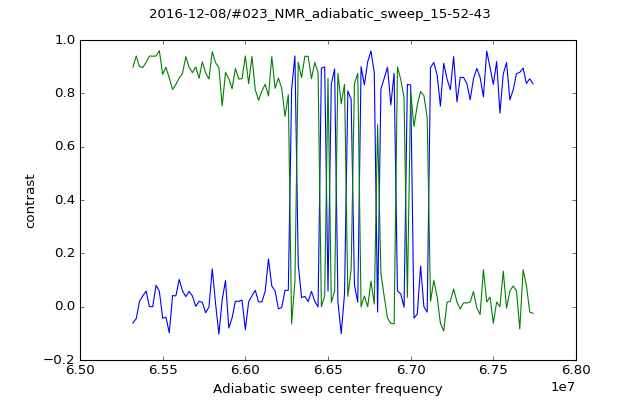

In [42]:
plot = qc.MatPlot(data.contrast_3_4)
plot.add(data.contrast_5_4)

## Adiabatic - frequency deviation versus ESR duration
This is a 2D scan of frequency deviation versus duration.
From this measurement, the minimum acceptable values for frequency deviation and ESR duration can be extracted.

In [ ]:
pulse = adiabatic_sweep_parameter.pulse_sequence['adiabatic_sweep']
adiabatic_deviation_parameter = general_parameters.AttributeParameter(object=pulse, attribute='frequency_deviation')
adiabatic_duration_parameter = general_parameters.AttributeParameter(object=pulse, attribute='duration')

adiabatic_deviation_vals = list(np.logspace(5.5, 7.8, 8))
adiabatic_duration_vals = list(np.logspace(-2.7, -0.3, 8))

In [ ]:
adiabatic_sweep_parameter.pulse_sequence['read'].duration = 100
adiabatic_sweep_parameter.setup(samples=400)
adiabatic_sweep_parameter(frequency_center)
data = qc.Loop(adiabatic_deviation_parameter[adiabatic_deviation_vals]
              ).loop(adiabatic_duration_parameter[adiabatic_duration_vals]
                    ).each(adiabatic_sweep_parameter
                          ).run(name='adiabatic_deviation_vs_duration',
                                progress_interval=True)

In [ ]:
plot = qc.MatPlot(subplots=(1,2), figsize=(12,5), interval=10)
plot.add(data.contrast, subplot=1, nticks=6)
plot.add(data.dark_counts, subplot=2, nticks=6)
# for ax in plot.subplots:
#     ax.set_xscale('log')
#     ax.set_yscale('log')
plot.fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Adiabatic - 2D scan

In [45]:
DF_DS_vals = list(np.linspace(0.413, 0.419, 8))
TGAC_vals = list(np.linspace(0.47,0.49, 8))

In [60]:
adiabatic_ESR_parameter.setup(samples=80, readout_threshold_voltage=readout_threshold_voltage,
                                save_traces=False)
data = qc.Loop(TGAC[TGAC_vals]
              ).loop(DF_DS[DF_DS_vals]
                    ).each(adiabatic_ESR_parameter
                          ).run(name='adiabatic_calibration',
                                progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-09/#014_adiabatic_calibration_12-44-37'
   <Type>   | <array_id>    | <array.name>  | <array.shape>
   Setpoint | TGAC_set      | TGAC          | (8,)
   Setpoint | DF_DS_set     | DF_DS         | (8, 8)
   Measured | fidelity_load | fidelity_load | (8, 8)
   Measured | fidelity_read | fidelity_read | (8, 8)
   Measured | up_proportion | up_proportion | (8, 8)
   Measured | dark_counts   | dark_counts   | (8, 8)
   Measured | contrast      | contrast      | (8, 8)
started at 2016-12-09 12:44:39


<IPython.core.display.Javascript object>


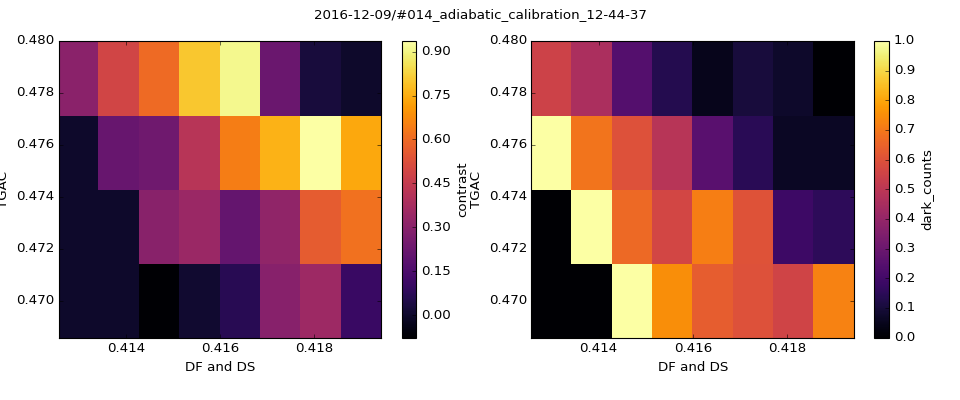

In [61]:
plot = CalibrationPlot(data)

## Flip nucleus

In [70]:
# Try to flip the nucleus
adiabatic_NMR_parameter(frequency_center_NMR)
adiabatic_NMR_parameter.samples = 1
adiabatic_NMR_parameter();

Found 3 peaks instead of two, increasing threshold
Found 3 peaks instead of two, increasing threshold
Found 3 peaks instead of two, increasing threshold
Found 3 peaks instead of two, increasing threshold
None of the load traces start with a loaded state


C:\Users\lab.BluG12Meas\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


## Adiabatic - Single point

In [62]:
DF_DS(0.417879)
TGAC(0.475386)

In [6]:
adiabatic_ESR_parameter(frequency_center_ESR['down'])
adiabatic_ESR_parameter.setup(samples=40, readout_threshold_voltage=readout_threshold_voltage, 
                                print_results=True)
%time adiabatic_ESR_parameter();

fidelity_load: 0.000
fidelity_read: 0.736
up_proportion: 0.730
dark_counts: 0.053
contrast: 0.677
Wall time: 6.6 s


(0.0,
 0.7356785714285714,
 0.72972972972972971,
 0.052631578947368418,
 0.67709815078236124)

## Find ESR frequency

In [38]:
find_ESR_parameter.samples=50
adiabatic_ESR_parameter.samples=150

In [18]:
find_ESR_parameter.setup(samples=40, print_results=True, readout_threshold_voltage=readout_threshold_voltage)
find_ESR_parameter()

[0.076923076923076927,
 -0.0019230769230769301,
 0.081081081081081086,
 0.66891891891891886,
 27951000000.0]

In [ ]:
partial_from_attr(adiabatic_ESR_parameter, find_ESR_parameter, 'ESR_frequency')

In [22]:
reload(silq.functions.general_functions)
from silq.functions.general_functions import printattr
printattr(find_ESR_parameter, 'frequency_ESR')

FindESR_Parameter.frequency_ESR = 27951000000.0


In [31]:
adiabatic_ESR_parameter.frequency_center

28800000000.0

In [28]:
find_ESR_parameter.frequency_ESR = 28.8e9

In [30]:
partial_from_attr(adiabatic_ESR_parameter, find_ESR_parameter, 'frequency_ESR')()

In [23]:
find_ESR_parameter.setup(samples=20, print_results=True, readout_threshold_voltage=readout_threshold_voltage)
data = qc.Loop(dummy_parameter[0:5:1]).each(qc.Task(adiabatic_NMR_parameter.setup),
                                            adiabatic_NMR_parameter,
                                            qc.Task(find_ESR_parameter.setup),
                                            find_ESR_parameter,
                                            qc.Task(partial_from_attr(adiabatic_ESR_parameter, find_ESR_parameter, 'frequency_ESR')),
#                                             qc.Task(partial_from_attr(print, adiabatic_ESR_parameter, 'pulse_sequence')),
                                            qc.Task(partial(printattr, find_ESR_parameter, 'frequency_ESR')),
                                            qc.Task(partial(printattr, adiabatic_ESR_parameter, 'frequency_center')),
                                            adiabatic_ESR_parameter
                                           ).run(name='test_find_ESR',
                                                 progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-09/#017_test_find_ESR_13-25-24'
   <Type>   | <array_id>        | <array.name>     | <array.shape>
   Setpoint | dummy_set         | dummy            | (5,)
   Measured | fidelity_load_1_0 | fidelity_load    | (5,)
   Measured | fidelity_read_1_1 | fidelity_read    | (5,)
   Measured | up_proportion_1_2 | up_proportion    | (5,)
   Measured | dark_counts_1_3   | dark_counts      | (5,)
   Measured | contrast_1_4      | contrast         | (5,)
   Measured | dark_counts_up    | dark_counts_up   | (5,)
   Measured | contrast_up       | contrast_up      | (5,)
   Measured | dark_counts_down  | dark_counts_down | (5,)
   Measured | contrast_down     | contrast_down    | (5,)
   Measured | ESR_frequency     | ESR_frequency    | (5,)
   Measured | fidelity_load_7_0 | fidelity_load    | (5,)
   Measured | fidelity_read_7_1 | fidelity_read    | (5,)
   Measured | up_proportion_7_2 | up_proportion    | (5,)
   Measured | dar

<IPython.core.display.Javascript object>


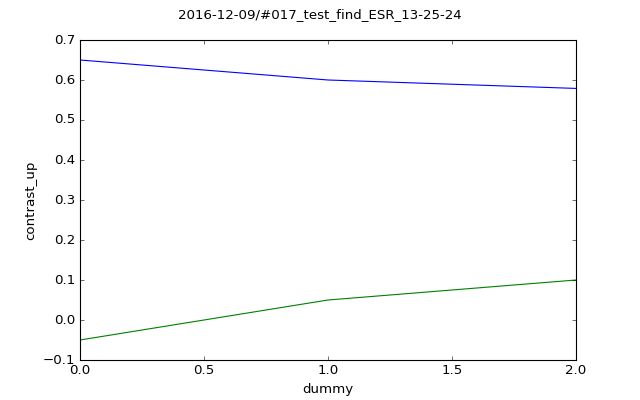

AttributeError: 'DataSet' object and its delegates have no attribute 'contrast_6_4'

In [24]:
plot = qc.MatPlot(data.contrast_up)
plot.add(data.contrast_down)
plot.add(data.contrast_6_4)

In [ ]:
# Initialization buffers showing how long it takes before it starts plunging

plot_traces(steered_controller.initialization_traces(), ax=axes[0])
plt.title('Initialization trace\nOutput signal')

# Post initialization buffer showing if blips occurred or not

plot_traces(steered_controller.post_initialization_traces()['chA'], ax=axes[1])
plt.title('Post initialization buffer\nOutput signal')

# Post initialization buffer of arbstudio showing when it starts plunging

plot_traces(steered_controller.post_initialization_traces()['chB'], ax=axes[2])
plt.title('Post initialization buffer\nArbStudio signal')

# Post initialization buffer of arbstudio showing when it starts plunging
# plot_traces(adiabatic_sweep_parameter.data['acquisition_traces']['output'], ax=axes[3])
# plt.title('Readout trace\nOutput signal')

plt.tight_layout()

# Dark counts
## Dark - Parameter settings

In [ ]:
dark_counts_parameter = measurement_parameters.dark_counts_parameter(layout=layout)

dark_counts_parameter.pulse_sequence['plunge'].enabled = False
dark_counts_parameter.pulse_sequence['adiabatic_sweep'].enabled = False

dark_counts_parameter.pulse_sequence['steered_initialization'].enabled = True
dark_counts_parameter.pulse_sequence['steered_initialization'].t_no_blip= 200
dark_counts_parameter.pulse_sequence['steered_initialization'].t_max_wait= 1000



dark_counts_parameter.pulse_sequence['read'].duration = 20

dark_counts_parameter.setup(readout_threshold_voltage, samples=20, print_results=True)
dark_counts_parameter.pulse_sequence

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(18,5))

# Initialization buffers showing how long it takes before it starts plunging
plot_traces(steered_controller.initialization_traces(), ax=axes[0])
plt.title('Initialization trace\nOutput signal')

# Post initialization buffer showing if blips occurred or not
plot_traces(steered_controller.post_initialization_traces()['A'], ax=axes[1])
plt.title('Post initialization buffer\nOutput signal')

# Post initialization buffer of arbstudio showing when it starts plunging
plot_traces(steered_controller.post_initialization_traces()['C'], ax=axes[2])
plt.title('Post initialization buffer\nArbStudio signal')

# Post initialization buffer of arbstudio showing when it starts plunging
plot_traces(adiabatic_sweep_parameter.traces['output'], ax=axes[3])
plt.title('Readout trace\nOutput signal')

plt.tight_layout()

## Dark - Single point

In [ ]:
EPR_parameter.setup(samples=150, print_results=True)
EPR_parameter();

# Read level sweep (to be fixed)

In [ ]:
variable_read_parameter.setup(samples=100)
data = qc.Loop(variable_read_parameter[-1.5:2.5:0.04]
                     ).each(variable_read_parameter
                           ).run(name='variable_read',
                                progress_interval=True)

In [ ]:
plotQ = qc.QtPlot()
plotQ.add(data.Channel_A_signal)

plotQ = qc.QtPlot()
plotQ.add(data.Channel_C_signal)

# T1 measurement

## T1 - Parameter settings

In [14]:
T1_parameter = measurement_parameters.T1_Parameter(layout=layout)

T1_parameter.pulse_sequence['empty'].enabled = False
T1_parameter.pulse_sequence['steered_initialization'].enabled = True
T1_parameter.pulse_sequence['steered_initialization'].t_buffer = 30
T1_parameter.pulse_sequence['steered_initialization'].t_no_blip = 120
T1_parameter.pulse_sequence['steered_initialization'].t_max_wait = 500
T1_parameter.pulse_sequence['adiabatic_sweep'].enabled = True
T1_parameter.pulse_sequence['adiabatic_sweep'].frequency_center=frequency_center_ESR['up']
T1_parameter.pulse_sequence['adiabatic_sweep'].frequency_deviation=10e6
T1_parameter.pulse_sequence['adiabatic_sweep'].duration = 0.2
T1_parameter.pulse_sequence['adiabatic_sweep'].t_start = 4
T1_parameter.pulse_sequence['plunge'].amplitude = 1.8
T1_parameter.pulse_sequence['plunge'].duration = 5
T1_parameter.pulse_sequence['read'].duration = 40
setup_T1 = partial(T1_parameter.setup, readout_threshold_voltage, samples=80,
                   save_traces=True)
setup_T1()

In [97]:
# Additional parameter setups

# PR
adiabatic_sweep_parameter.pulse_sequence['empty'].enabled = False
adiabatic_sweep_parameter.pulse_sequence['plunge'].amplitude = 1.8
adiabatic_sweep_parameter.pulse_sequence['plunge'].duration = 5
adiabatic_sweep_parameter.pulse_sequence['steered_initialization'].enabled = True
adiabatic_sweep_parameter.pulse_sequence['steered_initialization'].t_buffer = 30
adiabatic_sweep_parameter.pulse_sequence['steered_initialization'].t_no_blip = 120
adiabatic_sweep_parameter.pulse_sequence['steered_initialization'].t_max_wait = 500
adiabatic_sweep_parameter.pulse_sequence['adiabatic_sweep'].frequency_deviation=10e6
adiabatic_sweep_parameter.pulse_sequence['adiabatic_sweep'].duration = 0.2
adiabatic_sweep_parameter.pulse_sequence['adiabatic_sweep'].enabled = True
adiabatic_sweep_parameter.pulse_sequence['adiabatic_sweep'].t_start = 4
adiabatic_sweep_parameter.pulse_sequence['read'].duration=120

adiabatic_sweep_parameter.setup(readout_threshold_voltage, samples=250, save_traces=True)

# dark counts
dark_counts_parameter = measurement_parameters.dark_counts_parameter(layout=layout)
dark_counts_parameter.pulse_sequence['plunge'].enabled = False
dark_counts_parameter.pulse_sequence['adiabatic_sweep'].enabled = False
dark_counts_parameter.pulse_sequence['steered_initialization'].enabled = True
dark_counts_parameter.pulse_sequence['steered_initialization'].t_no_blip = 200
dark_counts_parameter.pulse_sequence['steered_initialization'].t_max_wait = 1000
dark_counts_parameter.pulse_sequence['steered_initialization'].t_buffer = 30
dark_counts_parameter.pulse_sequence['read'].duration = 40

dark_counts_parameter.setup(readout_threshold_voltage, samples=250,save_traces=True)

## T1 - Single point

In [ ]:
T1_parameter(10000)
T1_parameter.print_results = True
%time up_proportion,number_traces_loaded = T1_parameter()

## T1 - single scan

In [98]:
# Calculate T1 durations
T1_wait_times = list(np.logspace(1, 3, num=10, base=10))

# Shuffle times
#np.random.shuffle(T1_wait_times)
print('Shuffled T1 wait times: {}'.format(T1_wait_times))

Shuffled T1 wait times: [10.0, 16.681005372000591, 27.825594022071243, 46.415888336127772, 77.426368268112697, 129.15496650148839, 215.44346900318823, 359.38136638046257, 599.48425031894089, 1000.0]


In [ ]:
# Single T1 sweep

data = qc.Loop(T1_parameter[T1_wait_times]
                     ).each(T1_parameter
                           ).run(name='T1_single_sweep')

plotQ = qc.MatPlot()
plotQ.add(data.up_proportion)

## T1 - Multiple scans

In [99]:
# Calculate T1 durations (shuffled)
T1_wait_times = list(np.logspace(1, 4, num=12, base=10))
#np.random.shuffle(T1_wait_times)
print('Shuffled T1 wait times: {}'.format(T1_wait_times))

Shuffled T1 wait times: [10.0, 18.738174228603839, 35.111917342151308, 65.793322465756788, 123.28467394420659, 231.01297000831579, 432.87612810830569, 811.13083078968725, 1519.9110829529332, 2848.0358684357989, 5336.6992312063076, 10000.0]


In [100]:
data = qc.Loop(dummy_parameter[0:30:1]
              ).each(qc.Task(find_ESR_parameter.setup),
                     qc.Task()
                     qc.Task(adiabatic_ESR_parameter.setup),
                     adiabatic_sweep_parameter,
                     qc.Task(dark_counts_parameter.setup),
                     dark_counts_parameter,
                     qc.Task(T1_parameter.setup),
                     qc.Loop(T1_parameter[T1_wait_times]).each(T1_parameter)
                    ).run(name='T1_data', progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-12-05/#060_T1_data_22-31-00'
   <Type>   | <array_id>              | <array.name>      | <array.shape>
   Setpoint | dummy_set               | dummy             | (30,)
   Measured | fidelity_load           | fidelity_load     | (30,)
   Measured | fidelity_read           | fidelity_read     | (30,)
   Measured | up_proportion_1_2       | up_proportion     | (30,)
   Measured | dark_counts             | dark_counts       | (30,)
   Measured | contrast                | contrast          | (30,)
   Measured | up_proportion_3_0       | up_proportion     | (30,)
   Measured | num_traces_loaded_3_1   | num_traces_loaded | (30,)
   Setpoint | T1_wait_time_set        | T1_wait_time      | (30, 12)
   Measured | up_proportion_5_0_0     | up_proportion     | (30, 12)
   Measured | num_traces_loaded_5_0_1 | num_traces_loaded | (30, 12)
started at 2016-12-05 22:31:04


<IPython.core.display.Javascript object>


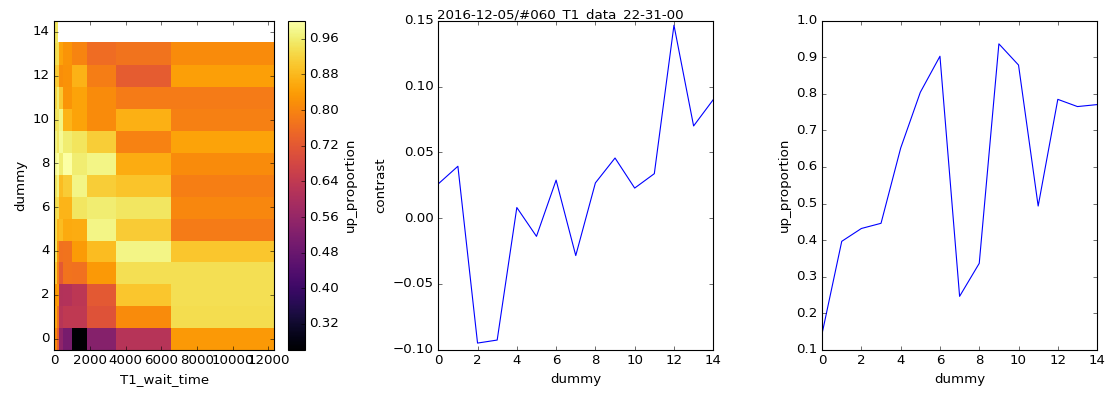

In [104]:
plot = qc.MatPlot(subplots=(1,3), figsize=(14,5))
plot.add(data.up_proportion_5_0_0, subplot=1)
plot.add(data.contrast, subplot=2)
plot.add(data.up_proportion_3_0, subplot=3)
plot.fig.tight_layout()

In [ ]:
plotQ = qc.MatPlot()
plotQ.add(data.up_proportion_5_0_0)

## T1 - Plunge voltage scan
This scan measures the contrast for a fixed wait time as the plunge voltage is varied

In [ ]:
T1_parameter.pulse_sequence['steered_initialization'].enabled = False

T1_parameter.pulse_sequence['plunge'].amplitude = 1.8

T1_parameter.pulse_sequence['adiabatic_sweep'].enabled = True
T1_parameter.pulse_sequence['adiabatic_sweep'].frequency_center=frequency_center
T1_parameter.pulse_sequence['adiabatic_sweep'].frequency_deviation=10e6
T1_parameter.pulse_sequence['adiabatic_sweep'].t_start=1
T1_parameter.pulse_sequence['adiabatic_sweep'].duration = 0.2

T1_parameter.pulse_sequence['read'].duration = 20

T1_parameter.setup(readout_threshold_voltage, samples=350)
T1_parameter.pulse_sequence

In [ ]:
pulse = T1_parameter.pulse_sequence['plunge']
plunge_voltage_parameter = general_parameters.AttributeParameter(object=pulse, attribute='voltage')

In [ ]:
T1_parameter(4000)
data = qc.Loop(plunge_voltage_parameter[1:2.5:0.1]
              ).each(qc.Task(T1_parameter.setup),
                     T1_parameter
                    ).run(name='T1_data', progress_interval=True)

In [ ]:
qc.MatPlot(data.up_proportion)

## T1 - Analysis

In [ ]:

T1_msmt = T1_Measurement(B0=1.2, location='2016-11-24/#006_T1_data_12-19-40')
T1_msmt.plot_T1()
print(T1_msmt.fit_result.fit_report())

In [ ]:
#data.arrays['up_proportion']
data.T1_wait_time_set[0]

In [ ]:
# Continuous T1 sweep
setup_ELRLR = partial(ELRLR_parameter.setup, samples=400, data_manager=data_manager_raw)
setup_T1 = partial(T1_parameter.setup, threshold_voltage=readout_threshold_voltage, samples=150, data_manager=data_manager_raw)
setup_ELRLR()
setup_T1()
data = qc.Loop(dummy_param[0:30:1]
              ).each(qc.Task(setup_ELRLR),
                     ELRLR_parameter,
                     qc.Task(setup_T1),
                     qc.Loop(T1_parameter[T1_wait_times]).each(T1_parameter)
                    ).run(name='T1_data', progress_interval=True)

# plotQ = qc.QtPlot()
# plotQ.add(data.up_proportion)

In [ ]:
data.sync()
print(data.T1_wait_time_set[0])
data.up_proportion_3_0_0[29]

# Plotting

In [ ]:
## Adiabatic - Detailed plot
fig, axes = plt.subplots(1,4, figsize=(18,5))

# Notes

To save individual traces when performing a measurement, set:
    
EPR_parameter.setup(samples=100, data_manager=data_manager_raw)

In [ ]:
steered_initialization = adiabatic_sweep_parameter.pulse_sequence['steered_initialization']

In [ ]:
adiabatic_sweep_parameter.pulse_sequence['load'].t_stop=15

In [ ]:
adiabatic_sweep_parameter.steered_initialization

In [ ]:
steered_controller.record_initialization_traces

To enable/disable steered initialization, use:

adiabatic_sweep_parameter.steered_intialization = True/False

This adds/removes the steered initialization "pulse" from the EPR_parameter.pulse_sequence
If steered_initialization is enabled, you can access and modify its properties via

steered_initialization = adiabatic_sweep_parameter.pulse_sequence['steered_initialization']

Note that steered initialization is currently only implemented for the adiabatic sweep, but is easy to add for other parameters, such as T1_parameter (just add the pulse)

steered_controller is the acquisition controller specifically for steered initialization
You can look at the initialization traces when using steered initialization.

First set the flag 
steered_controller.record_initialization_traces(True)

The initialization traces can then be accessed
steered_controller.initialization_traces()

You can also look at the first buffer after the pulseblaster.start() command has been set via
steered_controller.post_initialization_traces()
This can be useful for checking the delay between sending the command and plunging

To setup a parameter where steered initialization is enabled, you must pass it a readout threshold voltage every time.

adiabatic_sweep_parameter.setup(readout_threshold_voltage=threshold_voltage)

This threshold voltage can be obtained from an EPR scan (see T1_measurement):

EPR_parameter.setup(samples=30)
EPR_parameter()
traces_read = EPR_parameter.trace_segments['output']['read']
_, _, readout_threshold_voltage = analysis.find_high_low(traces_read)

In [ ]:
adiabatic_sweep_parameter.pulse_sequence.add(adiabatic_sweep_parameter._steered_initialization)
adiabatic_sweep_parameter.pulse_sequence.remove(adiabatic_sweep_parameter._steered_initialization)

To save raw traces, use:

EPR_parameter.setup(save_traces=True, data_manager=data_manager_raw)